# Generalization with OOP: The CBacktester Class

## Building the CBacktester Class from scratch: Instantiation

In [232]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.style.use('seaborn')

In [233]:
class CBacktester():
    '''This is a docstring'''
    def __init__(self, symbol, window, start, end, tc):
        self.symbol = symbol
        self.window = window
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "CBacktester: symbol = {}, window = {}, start = {}, end = {}, tc = {}".\
        format(self.symbol, self.window, self.start, self.end, self.tc)
        
    def get_data(self):
        raw = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.loc[:,["price"]].shift(1))
        self.data = raw
        return raw
    
    def prepare_data(self):
        data = self.data.copy()
        self.data = data
    
    def set_parameters(self, window = None):
        if window is not None:
            self.window = window
            
    def test_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = -np.sign(data['returns'].rolling(self.window).mean())
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace=True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        data['trades'] = data.position.diff().fillna(0).abs()
        data['ctrades'] = data.trades.cumsum()
        data['strategy_net'] = data.strategy - data.trades * (self.tc/data.price.mean())
        data['cstrategy_net'] = data.strategy_net.cumsum().apply(np.exp)
        self.results = data
        
        perf = data['cstrategy_net'].iloc[-1]
        outperf = perf - data['creturns'].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() before running plot_results()")
        else:
            self.results.loc[:,['creturns','cstrategy', 'cstrategy_net']]\
            .plot(title = "{} | {}-Bar Contrarian Window".format(self.symbol,\
            self.window),figsize=(12,8))
            
    def optimize_parameter(self, window_range):
        combinations = range(*window_range)
        
        results = []
        i = 0
        for comb in combinations:
            #Track iterations
            i+=1
            clear_output(wait=True)
            display('Iteration {} of {}. Testing window = {}'.\
            format(i, str(len(combinations)), comb))
            
            #test strategy
            self.set_parameters(comb)
            results.append(self.test_strategy()[0])
        
        #clearing output again so that there is no confusion 
        #about if the last iteration was the most optimal combination
        clear_output(wait=True)
        
        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]
        
        self.set_parameters(opt)
        self.test_strategy()
        self.plot_results()
        
        many_results = pd.DataFrame(data = combinations, columns = ["window"])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf

In [238]:
spread = 1.5
pips = 0.0001
insample = CBacktester("price", 3, "2018-01-01", "2019-12-30", spread/2*pips) #mult by 2 for a 'round trip', multiply by pips
insample

CBacktester: symbol = price, window = 3, start = 2018-01-01, end = 2019-12-30, tc = 7.500000000000001e-05

,price,returns,position,strategy,creturns,cstrategy,trades,ctrades,strategy_net,cstrategy_net
time,,,,,,,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,0.999079,1.000921,0.0,0.0,0.000921,1.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,0.998362,1.000203,0.0,0.0,-0.000718,1.000203
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222,0.997143,0.998981,0.0,0.0,-0.001222,0.998981
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757,0.996388,0.998225,0.0,0.0,-0.000757,0.998225
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004,0.996392,0.998229,0.0,0.0,0.000004,0.998229
...,...,...,...,...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591,0.0,1102.0,-0.002092,1.024287
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572,0.0,1102.0,-0.000018,1.024269
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420,0.0,1102.0,-0.000138,1.024127


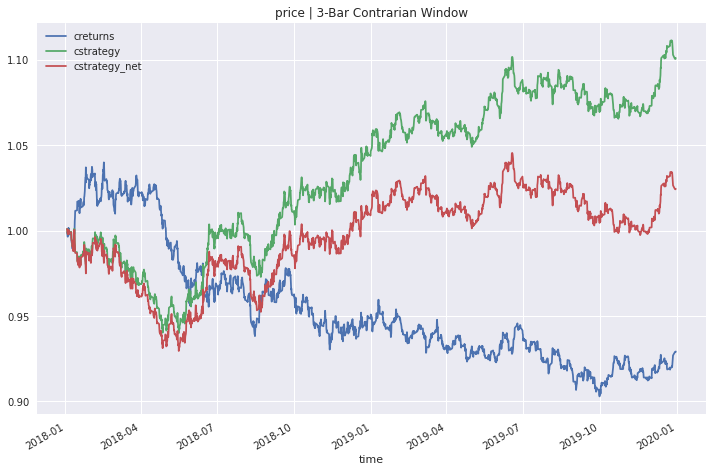

In [240]:
insample.test_strategy()
insample.plot_results()
insample.results

### checkpoint: instantation, get_data, set_parameters work

In [180]:
insample.prepare_data()

In [181]:
insample.test_strategy()

(1.024417, 0.095279)

(51, 1.263731)

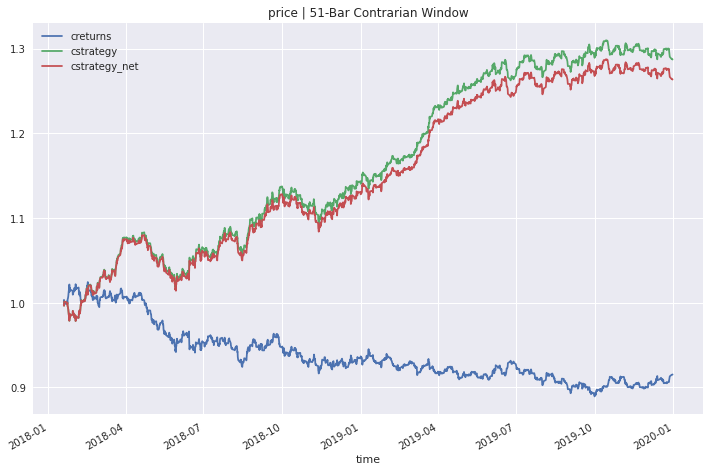

In [193]:
insample.optimize_parameter((1,252,1))

### Number of trades

In [214]:
print("From {} to {}, this strategy performed {:,.0f} trades over {:,.0f} days, \nan average of {:.2f} trades per day.\n\n Trading costs totaled {:,.2f}.".\
format(insample.start, insample.end, insample.results.ctrades[-1], insample.results.trades.describe().loc['count'],\
       insample.results.trades.describe().loc['count'] / insample.results.ctrades[-1],\
       insample.results.cstrategy[-1]-insample.results.cstrategy_net[-1]))

From 2018-01-01 to 2019-12-30, this strategy performed 284 trades over 2,018 days, 
an average of 7.11 trades per day.

 Trading costs totaled 0.02.


### Number of trades plot

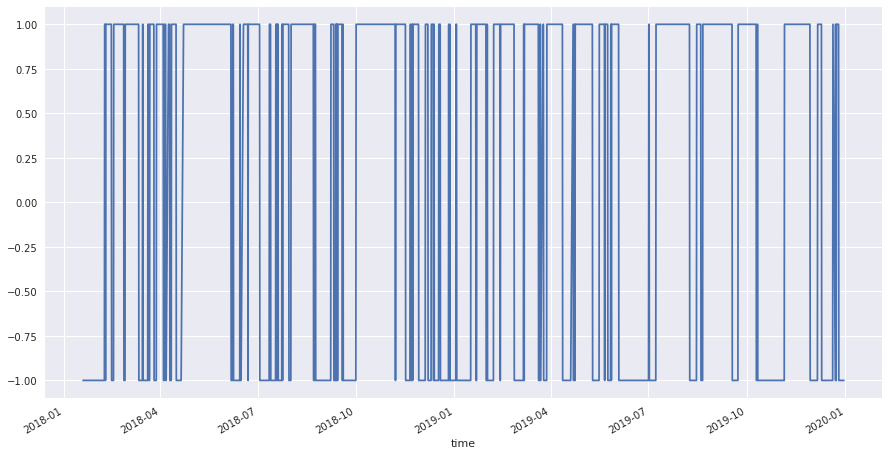

In [215]:
insample.results['position'].plot(figsize=(15,8))
plt.show()

In [216]:
insample.results_overview.sort_values(by=['performance'], ascending=False).head(10)

,window,performance
50,51,1.263731
43,44,1.262586
49,50,1.240611
54,55,1.236993
53,54,1.236465
52,53,1.233577
55,56,1.230465
37,38,1.218501
51,52,1.216066
44,45,1.206437


In [217]:
insample.results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2018 entries, 2018-01-18 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          2018 non-null   float64
 1   returns        2018 non-null   float64
 2   position       2018 non-null   float64
 3   strategy       2018 non-null   float64
 4   creturns       2018 non-null   float64
 5   cstrategy      2018 non-null   float64
 6   trades         2018 non-null   float64
 7   ctrades        2018 non-null   float64
 8   strategy_net   2018 non-null   float64
 9   cstrategy_net  2018 non-null   float64
dtypes: float64(10)
memory usage: 173.4 KB


__AUD/EUR__

## Method get_data()

## Setting new SMA Paramters

## Testing a Strategy

## Plotting the results

## Strategy Optimization

## Splitting get_data() and adding prepare_data() 

## String Representation & Docstrings